<a href="https://colab.research.google.com/github/AbelPhilippe/Quantum_Genetic_Algorithm/blob/main/Quantum_Genetic_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INSTALL LIBS**

In [ ]:
!pip install qiskit --quiet
!pip install qiskit[visualization] --quiet
!pip install deap --quiet
!pip install livelossplot --quiet

#!pip install qiskit-ibm-runtime --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 6.8 MB/s eta 0:00:00


# **IMPORT LIBS**

In [ ]:
import os
import time                                               # Add pauses between iterations.
import math                                               # Mathematical operations.
import numpy as np                                        # Manipulation of matrices and mathematical operations.
import random                                             # Random numbers.
import pickle
import matplotlib.pyplot as plt                           # Graphs.
import matplotlib.animation as manimation                 # (animation)
import pandas as pd                                       # Structured data manipulation.
import seaborn as sns                                     # Statistical data visualization.
import tqdm.notebook as nb                                # Progress bars
from IPython.display import clear_output
from IPython.display import display
from livelossplot import PlotLosses                                                   # Live loss plots.

from qiskit import ClassicalRegister                                                  # create classical registers
from qiskit import QuantumRegister                                                    # create quantum registers
from qiskit import QuantumCircuit                                                     # create quantum circuits
from qiskit import transpile

from qiskit.visualization import plot_histogram                                       # plot quantum circuits, measurements and results
from qiskit.primitives import StatevectorSampler as Sampler

#**QUANTUM GENETIC ALGORITHM (R. LAHOZ-BELTRA)**

In [ ]:
population = 50                   # Define here the population size
Genome = 4                        # Define here the chromosome length
generation_max=450                # Define here the maximum number of
                                  # generations/iterations

N = population
popSize=N+1
genomeLength=Genome+1
top_bottom=3
QuBitZero = np.array([[1],[0]])
QuBitOne = np.array([[0],[1]])
AlphaBeta = np.empty([top_bottom])
fitness = np.empty([popSize])
probability = np.empty([popSize])
qpv = np.empty([popSize, genomeLength, top_bottom])
nqpv = np.empty([popSize, genomeLength, top_bottom])
chromosome = np.empty([popSize, genomeLength],dtype=int)
child1 = np.empty([popSize, genomeLength, top_bottom])
child2 = np.empty([popSize, genomeLength, top_bottom])
best_chrom = np.empty([generation_max], dtype=int)

In [ ]:
# Global variables
theta=0;
iteration=0;
the_best_chrom=0;
generation=0;

In [ ]:
#########################################################
# QUANTUM POPULATION INITIALIZATION                     #
#########################################################

def Init_population():
    # Hadamard gate
    r2=math.sqrt(2.0)
    h=np.array([[1/r2,1/r2],[1/r2,-1/r2]])
    # Rotation Q-gate
    theta=0;
    rot =np.empty([2,2])
    # Initial population array (individual x chromosome)
    i=1; j=1;
    for i in range(1,popSize):
     for j in range(1,genomeLength):
        theta=np.random.uniform(0,1)*90
        theta=math.radians(theta)
        rot[0,0]=math.cos(theta); rot[0,1]=-math.sin(theta);
        rot[1,0]=math.sin(theta); rot[1,1]=math.cos(theta);
        AlphaBeta[0]=rot[0,0]*(h[0][0]*QuBitZero[0])+rot[0][1]*(h[0][1]*QuBitZero[1])
        AlphaBeta[1]=rot[1,0]*(h[1][0]*QuBitZero[0])+rot[1][1]*(h[1][1]*QuBitZero[1])
        # alpha squared
        qpv[i,j,0]=np.around(2*pow(AlphaBeta[0],2),2)
        # beta squared
        qpv[i,j,1]=np.around(2*pow(AlphaBeta[1],2),2)

In [ ]:
def Show_population():
    i=1; j=1;
    for i in range(1,popSize):
        print()
        print()
        print("qpv = ",i," : ")
        print()
        for j in range(1,genomeLength):
          print(qpv[i, j, 0],end="")
          print(" ",end="")
        print()
        for j in range(1,genomeLength):
          print(qpv[i, j, 1],end="")
          print(" ",end="")
    print()

In [ ]:
# p_alpha: probability of finding qubit in alpha state
def Measure(p_alpha):
    for i in range(1,popSize):
        print()
        for j in range(1,genomeLength):
            if p_alpha<=qpv[i, j, 0]:
                chromosome[i,j]=0
            else:
                chromosome[i,j]=1
            print(chromosome[i,j]," ",end="")
        print()
    print()


In [ ]:
# Pass 'generation' as an argument to the Fitness_evaluation function
def Fitness_evaluation(generation):
    i=1; j=1; fitness_total=0; sum_sqr=0;
    fitness_average=0; variance=0;
    for i in range(1,popSize):
        fitness[i]=0


#########################################################
# Let f(x)=abs(x-5/2+sin(x)) be a function that takes   #
# values in the range 0<=x<=15. Within this range f(x)  #
# has a maximum value at x=11 (binary is equal to 1011) #
#########################################################

    for i in range(1,popSize):
       x=0;
       for j in range(1,genomeLength):
           # translate from binary to decimal value
           x=x+chromosome[i,j]*pow(2,genomeLength-j-1)
           # replaces the value of x in the function f(x)
           y= np.fabs((x-5)/(2+np.sin(x)))
           # the fitness value is calculated below:
           # (Note that in this example is multiplied
           # by a scale value, e.g. 100)
           fitness[i]=y*100

#########################################################

       print("fitness = ",i," ",fitness[i])
       fitness_total=fitness_total+fitness[i]
    # Use N instead of population
    fitness_average=fitness_total/N
    i=1;
    # Use N instead of population
    while i<=N:
        sum_sqr=sum_sqr+pow(fitness[i]-fitness_average,2)
        i=i+1
    # Use N instead of population
    variance=sum_sqr/N
    if variance<=1.0e-4:
        variance=0.0
    # Best chromosome selection
    the_best_chrom=0;
    fitness_max=fitness[1];
    for i in range(1,popSize):
        if fitness[i]>=fitness_max:
            fitness_max=fitness[i]
            the_best_chrom=i
    # Ensure the index is an integer when assigning
    best_chrom[generation]=int(the_best_chrom)
    # Statistical output
    f = open("output.dat","a")
    f.write(str(generation)+" "+str(fitness_average)+"\n")
    f.write(" \n")
    f.close()
    print("Population size = ",popSize - 1)
    print("mean fitness = ",fitness_average)
    print("variance = ",variance," Std. deviation = ",math.sqrt(variance))
    # Access best_chrom with integer index
    print("fitness max = ",best_chrom[generation])
    print("fitness sum = ",fitness_total)

In [ ]:
#########################################################
# QUANTUM ROTATION GATE                                 #
#########################################################

# Pass 'generation' as an argument to the rotation function
def rotation(generation):
    rot=np.empty([2,2])
    # Lookup table of the rotation angle
    for i in range(1,popSize):
       for j in range(1,genomeLength):
           # Ensure the index is an integer when accessing best_chrom
           if fitness[i]<fitness[best_chrom[generation]]:
             # if chromosome[i,j]==0 and chromosome[best_chrom[generation],j]==0:
               # Ensure the index is an integer when accessing best_chrom
               if chromosome[i,j]==0 and chromosome[best_chrom[generation],j]==1:
                   # Define the rotation angle: delta_theta (e.g. 0.0785398163)
                   delta_theta=0.0785398163
                   rot[0,0]=math.cos(delta_theta); rot[0,1]=-math.sin(delta_theta);
                   rot[1,0]=math.sin(delta_theta); rot[1,1]=math.cos(delta_theta);
                   nqpv[i,j,0]=(rot[0,0]*qpv[i,j,0])+(rot[0,1]*qpv[i,j,1])
                   nqpv[i,j,1]=(rot[1,0]*qpv[i,j,0])+(rot[1,1]*qpv[i,j,1])
                   qpv[i,j,0]=round(nqpv[i,j,0],2)
                   qpv[i,j,1]=round(1-nqpv[i,j,0],2)
               # Ensure the index is an integer when accessing best_chrom
               if chromosome[i,j]==1 and chromosome[best_chrom[generation],j]==0:
                   # Define the rotation angle: delta_theta (e.g. -0.0785398163)
                   delta_theta=-0.0785398163
                   rot[0,0]=math.cos(delta_theta); rot[0,1]=-math.sin(delta_theta);
                   rot[1,0]=math.sin(delta_theta); rot[1,1]=math.cos(delta_theta);
                   nqpv[i,j,0]=(rot[0,0]*qpv[i,j,0])+(rot[0,1]*qpv[i,j,1])
                   nqpv[i,j,1]=(rot[1,0]*qpv[i,j,0])+(rot[1,1]*qpv[i,j,1])
                   qpv[i,j,0]=round(nqpv[i,j,0],2)
                   qpv[i,j,1]=round(1-nqpv[i,j,0],2)
             # if chromosome[i,j]==1 and chromosome[best_chrom[generation],j]==1:

#########################################################
# X-PAULI QUANTUM MUTATION GATE                         #
#########################################################

# pop_mutation_rate: mutation rate in the population
# mutation_rate: probability of a mutation of a bit
def mutation(pop_mutation_rate, mutation_rate):

    for i in range(1,popSize):
        up=np.random.randint(0, 101) / 100
        if up<=pop_mutation_rate:
            for j in range(1,genomeLength):
                um=np.random.randint(0, 101) / 100
                if um<=mutation_rate:
                    nqpv[i,j,0]=qpv[i,j,1]
                    nqpv[i,j,1]=qpv[i,j,0]
                else:
                    nqpv[i,j,0]=qpv[i,j,0]
                    nqpv[i,j,1]=qpv[i,j,1]
        else:
            for j in range(1,genomeLength):
                nqpv[i,j,0]=qpv[i,j,0]
                nqpv[i,j,1]=qpv[i,j,1]
    for i in range(1,popSize):
        for j in range(1,genomeLength):
            qpv[i,j,0]=nqpv[i,j,0]
            qpv[i,j,1]=nqpv[i,j,1]

In [ ]:
#########################################################
# PERFORMANCE GRAPH                                     #
#########################################################
def plot_Output():
    # Check if the output file exists before trying to load it
    if os.path.exists('output.dat'):
        data = np.loadtxt('output.dat')
        # Check if data is not empty
        if data.size > 0:
            # If data is 1D (only one generation logged), reshape it
            if data.ndim == 1:
                data = data.reshape(1, -1)
            # plot the first column as x, and second column as y
            x=data[:,0]
            y=data[:,1]
            plt.plot(x,y)
            plt.xlabel('Generation')
            plt.ylabel('Fitness average')
            # Adjust xlim if needed based on actual data, or keep it fixed
            plt.xlim(0.0, generation_max)
            plt.show()
        else:
            print("output.dat is empty. Cannot plot.")
    else:
        print("output.dat not found. Cannot plot.")

A saída de streaming foi truncada nas últimas 5000 linhas.
fitness =  11   165.82933319708366
fitness =  12   599.9941239879686
fitness =  13   599.9941239879686
fitness =  14   165.82933319708366
fitness =  15   599.9941239879686
fitness =  16   343.4115726124435
fitness =  17   599.9941239879686
fitness =  18   599.9941239879686
fitness =  19   599.9941239879686
fitness =  20   599.9941239879686
fitness =  21   343.4115726124435
fitness =  22   343.4115726124435
fitness =  23   343.4115726124435
fitness =  24   599.9941239879686
fitness =  25   343.4115726124435
fitness =  26   599.9941239879686
fitness =  27   599.9941239879686
fitness =  28   250.0
fitness =  29   93.40905659053925
fitness =  30   599.9941239879686
fitness =  31   93.40905659053925
fitness =  32   93.40905659053925
fitness =  33   343.4115726124435
fitness =  34   599.9941239879686
fitness =  35   599.9941239879686
fitness =  36   165.82933319708366
fitness =  37   165.82933319708366
fitness =  38   599.99412398796

<ipython-input-21-3642ab56fcae>:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  AlphaBeta[0]=rot[0,0]*(h[0][0]*QuBitZero[0])+rot[0][1]*(h[0][1]*QuBitZero[1])
<ipython-input-21-3642ab56fcae>:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  AlphaBeta[1]=rot[1,0]*(h[1][0]*QuBitZero[0])+rot[1][1]*(h[1][1]*QuBitZero[1])


A saída de streaming foi truncada nas últimas 5000 linhas.
fitness =  16   599.9941239879686
fitness =  17   599.9941239879686
fitness =  18   599.9941239879686
fitness =  19   599.9941239879686
fitness =  20   599.9941239879686
fitness =  21   599.9941239879686
fitness =  22   599.9941239879686
fitness =  23   343.4115726124435
fitness =  24   599.9941239879686
fitness =  25   599.9941239879686
fitness =  26   599.9941239879686
fitness =  27   599.9941239879686
fitness =  28   140.77215714628977
fitness =  29   93.40905659053925
fitness =  30   599.9941239879686
fitness =  31   93.40905659053925
fitness =  32   599.9941239879686
fitness =  33   343.4115726124435
fitness =  34   599.9941239879686
fitness =  35   599.9941239879686
fitness =  36   165.82933319708366
fitness =  37   165.82933319708366
fitness =  38   599.9941239879686
fitness =  39   599.9941239879686
fitness =  40   599.9941239879686
fitness =  41   599.9941239879686
fitness =  42   599.9941239879686
fitness =  43   599.

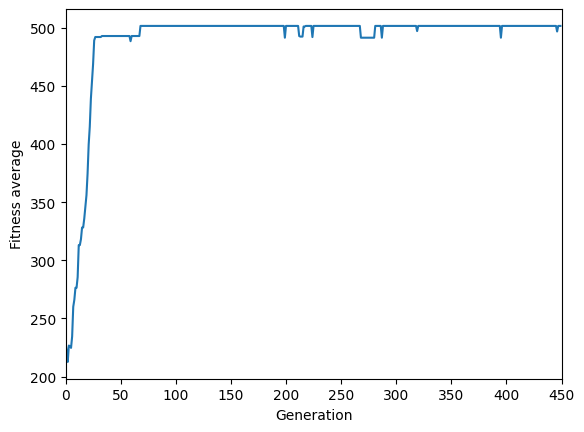

In [ ]:
def QGA():
    # Ensure generation starts at 0 for indexing best_chrom
    generation=0;
    print("============== GENERATION: ",generation," =========================== ")
    print()
    Init_population()
    Show_population()
    Measure(0.5)
    # Pass the current generation to Fitness_evaluation
    Fitness_evaluation(generation)
    while (generation<generation_max-1):
      # Ensure the index is an integer when accessing best_chrom
      print("The best of generation [",generation,"] ", best_chrom[generation])
      print()
      print("============== GENERATION: ",generation+1," =========================== ")
      print()
      # Pass the current generation to the rotation function
      rotation(generation)
      mutation(0.01,0.001) # Corrected mutation rate as in the test block
      generation=generation+1
      Measure(0.5)
      # Pass the current generation to Fitness_evaluation
      Fitness_evaluation(generation)

print ("""QUANTUM GENETIC ALGORITHM""")
input("Press Enter to continue...")
# Clear the output.dat file before starting a new run if it exists
if os.path.exists("output.dat"):
    os.remove("output.dat")
QGA()
plot_Output()

# **TRAVELING SALESMAN PROBLEM**

In [ ]:
def generate_random_locations(num_cities, limite=100):
    return [np.random.rand(2) * limite for _ in range(num_cities)]


def calculate_distance_matrix(locations):
    num_cities = len(locations)
    distances = [[0] * num_cities for _ in range(num_cities)]

    for i in range(num_cities):
        for j in range(i + 1, num_cities):
            distance = np.linalg.norm(locations[j] - locations[i])
            distances[i][j] = distance
            distances[j][i] = distance

    return distances


def calculate_total_distance(indices, distances):
    distance = distances[indices[-1]][indices[0]]
    for i in range(len(indices) - 1):
        distance += distances[indices[i]][indices[i + 1]]
    return distance

In [ ]:
def plotar_caminho(locations, indices, nome="TSP Aleatório"):
    """
    Plota o caminho entre as cidades conforme a ordem dada pelos índices.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(*zip(*locations), marker='o', color='red')
    caminho = [locations[i] for i in indices] + [locations[indices[0]]]
    plt.plot(*zip(*caminho), linestyle='-', color='blue')
    plt.title(nome)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()

In [ ]:
num_cities = 15
nome_problema = "tsp_aleatorio"

locations = generate_random_locations(num_cities)
locations

[array([31.9023123 , 59.16043504]),
 array([84.43891831, 59.05204322]),
 array([26.94710807, 90.80742458]),
 array([47.9900076 ,  4.23575606]),
 array([82.73893098, 70.68423156]),
 array([22.81105288, 67.9187744 ]),
 array([ 4.96009398, 39.43876547]),
 array([33.84665407, 89.05464635]),
 array([93.07917714, 21.32633272]),
 array([10.52987456, 67.21196367]),
 array([96.6905311 , 47.12384407]),
 array([31.99084759, 59.14147139]),
 array([57.22050431, 27.61862157]),
 array([91.88167226, 45.86364488]),
 array([65.39004026,  6.34158626])]

In [ ]:
def executeTSP():

    # Etapa 2: Calcular distâncias
    distances = calculate_distance_matrix(locations)

    # Etapa 3: Gerar solução aleatória
    solution = random.sample(range(num_cities), num_cities)
    total_distance = calculate_total_distance(solution, distances)

    print(f"Problema: {nome_problema}")
    print("Solução aleatória:", solution)
    print("Distância total:", total_distance)

    # Etapa 5: Plotar
    plotar_caminho(locations, solution, nome=nome_problema)

Problema: tsp_aleatorio
Solução aleatória: [5, 12, 7, 13, 10, 0, 3, 14, 9, 2, 1, 6, 8, 4, 11]
Distância total: 800.0609933756579


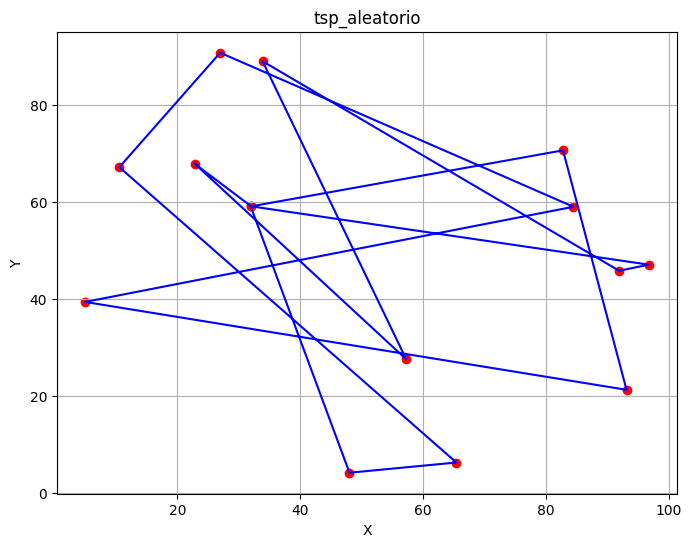

In [ ]:
executeTSP()

# **GENETIC ALGORITHMS**

In [ ]:
def create_cell():
 return dict(health = random.randint(1, 100))

In [ ]:
def birth(offspring):
 return [create_cell() for i in range(offspring)]

In [ ]:
cells = birth(10)
print(cells)

[{'health': 64}, {'health': 88}, {'health': 93}, {'health': 47}, {'health': 87}, {'health': 92}, {'health': 73}, {'health': 33}, {'health': 24}, {'health': 64}]


In [ ]:
#@title Dataset Parameters  { run: "auto" }
rprd_rate = 50                   #@param {type:"slider", min:1, max:50, step:1}
death_rate = 25                  #@param {type:"slider", min:1, max:25, step:1}
initial_offspring = 10           #@param {type:"slider", min:1, max:25, step:1}
N = 50                           #@param {type:"slider", min:1, max:50, step:1}
genes = 100                      #@param {type:"slider", min:1, max:100, step:1}
mutate_rate = 10                 #@param {type:"slider", min:1, max:25, step:1}
mutate_range = 5                 #@param {type:"slider", min:1, max:25, step:1}
generations = 30                 #@param {type:"slider", min:1, max:50, step:1}

In [ ]:
rprd_bounds = (0.5, 1.0)
death_bounds = (0.0, 0.2)

In [ ]:
def reproduce(cells):
 return [create_cell() for cell in cells if random.randint(1, 100) < rprd_rate]
def death(cells):
 return [cell for cell in cells if random.randint(1, 100) > death_rate]
def run_generation(cells):
 cells.extend(reproduce(cells))
 return death(cells)

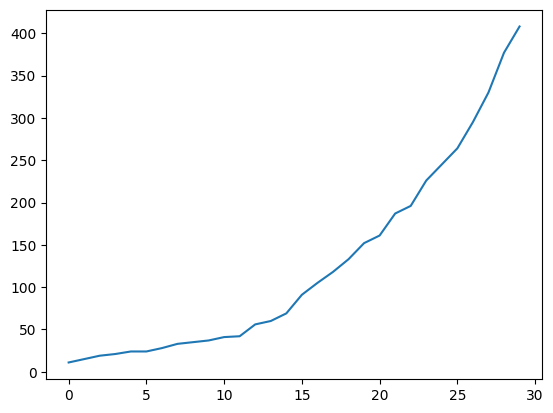

In [ ]:
cells = birth(initial_offspring)
history = []
for i in range(generations):
 cells = run_generation(cells)
 history.append(len(cells))
 clear_output()
 plt.plot(history)
 plt.show()
 time.sleep(1)

In [ ]:
def create_cell():
 return dict(
 health = random.randint(1, 100),
 strength = random.randint(1, 100)
 )
def birth(offspring):
 return [create_cell() for i in range(offspring)]
def evaluate(cells):
 for cell in cells:
  cell["health"] *= cell["strength"]/100
  return cells

In [ ]:
def reproduce(cells):
 return [create_cell() for cell in cells if rprd_bounds[0] <= cell["health"] <= rprd_bounds[1]]
def death(cells):
 return [create_cell() for cell in cells if cell["health"] > rprd_bounds[0]]
def run_generation(cells):
 cells = evaluate(cells)
 cells.extend(reproduce(cells))
 return death(cells)

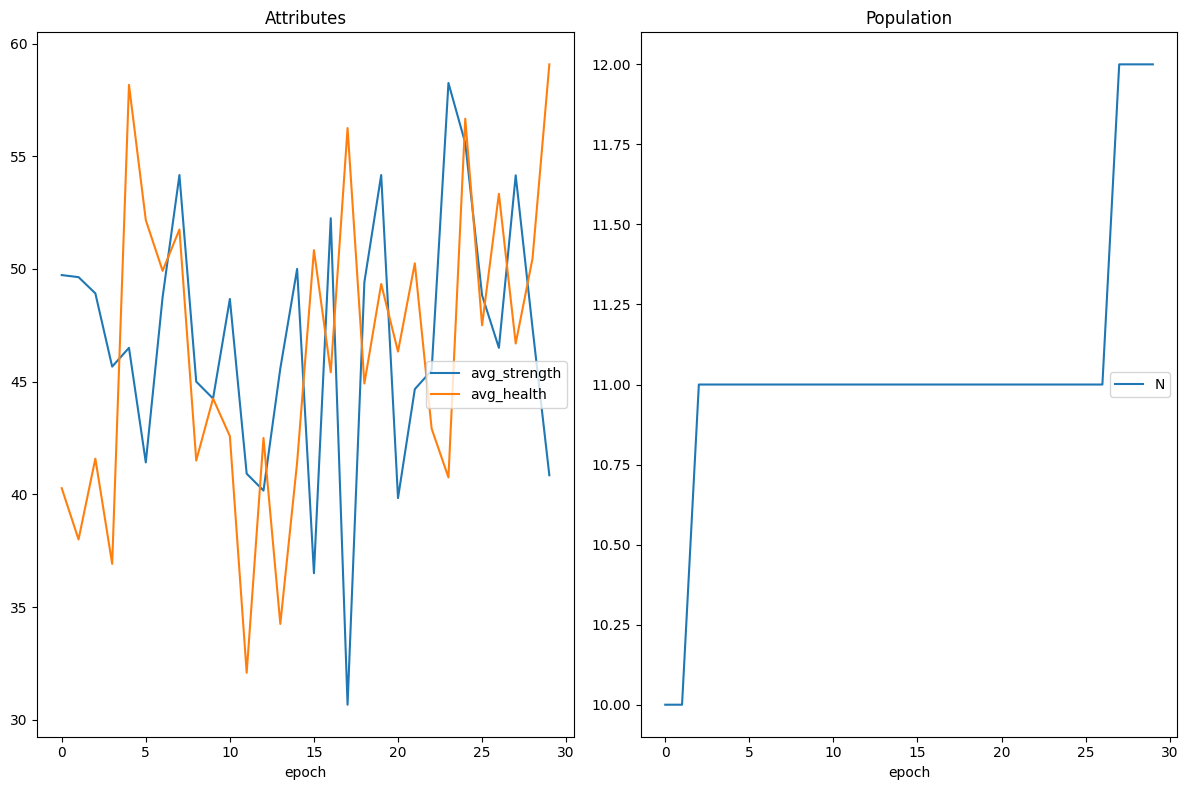

Attributes
	avg_strength     	 (min:   30.667, max:   58.250, cur:   40.846)
	avg_health       	 (min:   32.083, max:   59.077, cur:   59.077)
Population
	N                	 (min:   10.000, max:   12.000, cur:   12.000)


In [ ]:
cells = birth(initial_offspring)
groups = {'Population': ['N'], 'Attributes' : ['avg_strength','avg_health']}
liveloss = PlotLosses(groups=groups)
history = {}
for i in range(generations):
  cells = run_generation(cells)
  history["N"] = len(cells)
  history["avg_strength"] = sum([cell["strength"] for cell in
                                 cells])/(len(cells)+1)
  history["avg_health"] = sum([cell["health"] for cell in
  cells])/(len(cells)+1)
  liveloss.update(history)
  liveloss.send()

In [ ]:
def create_cell(parent1, parent2):
  if parent1 is None or parent2 is None:
    return dict(
        fitness = 0,
        a = random.randint(1, 100),
        b = random.randint(1, 100),
        c = random.randint(1, 100)
      )
  else:
    return dict(
        fitness = 0,
        a = (parent1["a"] + parent2["a"])/2,
        b = (parent1["b"] + parent2["b"])/2,
        c = (parent1["c"] + parent2["c"])/2,
      )

In [ ]:
def birth(offspring):
  return [create_cell(None, None) for i in range(offspring)]

In [ ]:
#@title Cells Parameters  { run: "auto" }
mutate_range = 20                #@param {type:"slider", min:1, max:25, step:1}
generations = 30                 #@param {type:"slider", min:1, max:50, step:1}

In [ ]:
def clamp(value, min_val, max_val):
    return max(min_val, min(value, max_val))

def mutate(cells):
    for cell in cells:
        if random.randint(1, 100) < mutate_rate:
            cell["a"] = clamp(cell["a"] + random.randint(-mutate_range, mutate_range), 1, 100)
            cell["b"] = clamp(cell["b"] + random.randint(-mutate_range, mutate_range), 1, 100)
            cell["c"] = clamp(cell["c"] + random.randint(-mutate_range, mutate_range), 1, 100)
    return cells

In [ ]:
def evaluate(cells):
    for cell in cells:
        cell["fitness"] = 2 * cell["a"] - cell["b"] + cell["c"]
    return cells

In [ ]:
def reproduce(cells):
    parents = sorted(cells, key=lambda d: d["fitness"])[int(len(cells) / 2):]
    children = []
    for _ in range(len(parents) * 2):
        mates = random.sample(parents, 2)
        children.append(create_cell(mates[0], mates[1]))
    return mutate(children)

In [ ]:
def run_generation(cells):
 cells = evaluate(cells)
 cells = reproduce(cells)
 cells = evaluate(cells)
 return cells

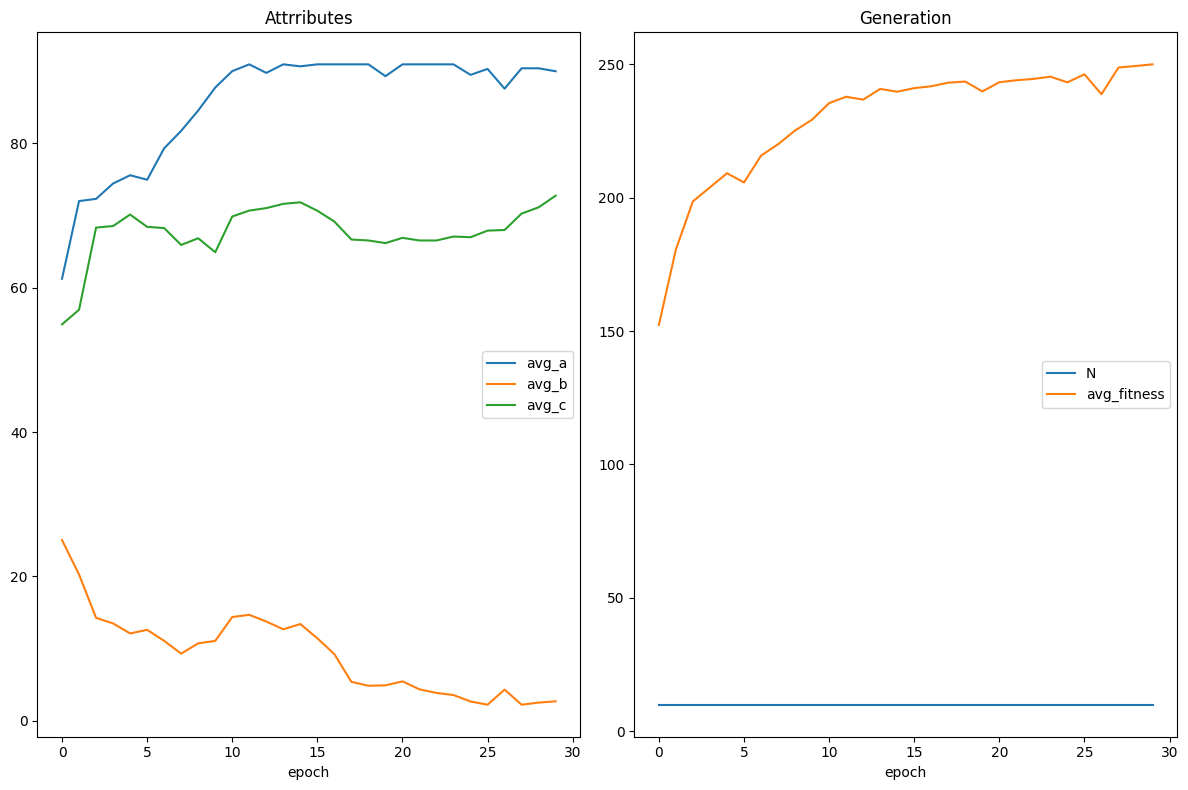

Attrributes
	avg_a            	 (min:   61.227, max:   90.909, cur:   89.955)
	avg_b            	 (min:    2.246, max:   25.045, cur:    2.713)
	avg_c            	 (min:   54.909, max:   72.726, cur:   72.726)
Generation
	N                	 (min:   10.000, max:   10.000, cur:   10.000)
	avg_fitness      	 (min:  152.318, max:  249.922, cur:  249.922)


In [ ]:
cells = birth(initial_offspring)

groups = {'Generation': ['population','avg_fitness'],
          'Attrributes': ["avg_a", "avg_b", "avg_c"]}
liveloss = PlotLosses(groups=groups)

history = {}
for i in range(generations):
  cells = run_generation(cells)
  history["population"] = len(cells)
  history["avg_fitness"] = sum([cell["fitness"] for cell in cells])/(len(cells)+1)
  history["avg_a"] = sum([cell["a"] for cell in cells])/(len(cells)+1)
  history["avg_b"] = sum([cell["b"] for cell in cells])/(len(cells)+1)
  history["avg_c"] = sum([cell["c"] for cell in cells])/(len(cells)+1)
  liveloss.update(history)
  liveloss.send()

# **TRAVELING SALESMAN PROBLEM (CLASSICAL GENETIC ALGORITHM)**

In [ ]:
def initial_population(pop_size, num_cities):
    return [random.sample(range(num_cities), num_cities) for _ in range(pop_size)]


def tournament(population, distances, k=3):
    selected = random.sample(population, k)
    selected.sort(key=lambda c: calculate_total_distance(c, distances))
    return selected[0]


def crossover_order(father1, father2):
    a, b = sorted(random.sample(range(len(father1)), 2))
    child = [None] * len(father1)
    child[a:b+1] = father1[a:b+1]

    p2 = [c for c in father2 if c not in child]
    j = 0
    for i in range(len(child)):
        if child[i] is None:
            child[i] = p2[j]
            j += 1
    return child

def mutation_swap(path, taxa_mutacao):
    if random.random() < taxa_mutacao:
        a, b = random.sample(range(len(path)), 2)
        path[a], path[b] = path[b], path[a]
    return path

In [ ]:
def genetic_algorithm(locations, distances, num_generations=200, pop_size=100, mutation_rate=0.05):
    num_cities = len(locations)
    population = initial_population(pop_size, num_cities)

    best_path = min(population, key=lambda c: calculate_total_distance(c, distances))
    best_distance = calculate_total_distance(best_path, distances)

    for generation in range(num_generations):
        new_population = []

        for _ in range(pop_size):
            father1 = tournament(population, distances)
            father2 = tournament(population, distances)

            child = crossover_order(father1, father2)
            child = mutation_swap(child, mutation_rate)

            new_population.append(child)

        population = new_population

        atual_melhor = min(population, key=lambda c: calculate_total_distance(c, distances))
        atual_distancia = calculate_total_distance(atual_melhor, distances)

        if atual_distancia < best_distance:
            best_path = atual_melhor
            best_distance = atual_distancia

        if generation % 10 == 0:
            print(f"Geração {generation}: Melhor distância = {best_distance:.2f}")

    return best_path, best_distance

In [ ]:
def executeCGA():
    distances = calculate_distance_matrix(locations)

    print("Executando algoritmo genético...\n")
    best_path, melhor_distancia = genetic_algorithm(locations, distances)

    print("\nMelhor solução encontrada:")
    print("Path:", best_path)
    print("Distance:", melhor_distancia)

    plotar_caminho(locations, best_path, nome="TSP With Classical Genetic Algorithm")

Executando algoritmo genético...

Geração 0: Melhor distância = 539.74
Geração 10: Melhor distância = 373.62
Geração 20: Melhor distância = 338.75
Geração 30: Melhor distância = 338.75
Geração 40: Melhor distância = 338.75
Geração 50: Melhor distância = 338.75
Geração 60: Melhor distância = 338.75
Geração 70: Melhor distância = 338.75
Geração 80: Melhor distância = 338.75
Geração 90: Melhor distância = 338.75
Geração 100: Melhor distância = 338.75
Geração 110: Melhor distância = 338.75
Geração 120: Melhor distância = 338.75
Geração 130: Melhor distância = 338.75
Geração 140: Melhor distância = 338.75
Geração 150: Melhor distância = 338.75
Geração 160: Melhor distância = 338.75
Geração 170: Melhor distância = 338.75
Geração 180: Melhor distância = 338.75
Geração 190: Melhor distância = 338.75

Melhor solução encontrada:
Path: [11, 0, 7, 2, 5, 9, 6, 12, 3, 14, 8, 10, 13, 1, 4]
Distance: 338.7476600748677


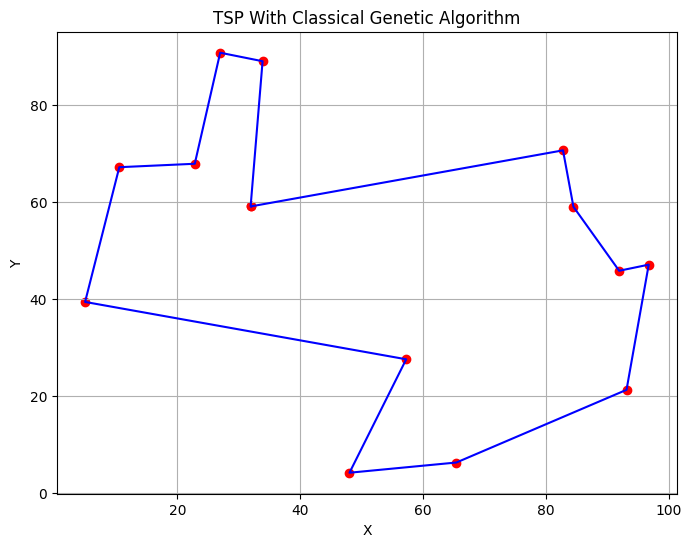

In [ ]:
executeCGA()

# **TRAVELING SALESMAN PROBLEM (QUANTUM GENETIC ALGORITHM)**

In [ ]:
def initial_quantum_population(pop_size, num_cities):
    return np.full((pop_size, num_cities, 2), 1/np.sqrt(2))  # [|α|, |β|] = [1/√2, 1/√2]

def measure_individual(qubits):
    bits = []
    for q in qubits:
        prob_0 = q[0] ** 2
        bit = 0 if random.random() < prob_0 else 1
        bits.append(bit)
    return bits

def measure_population(pop_qubits):
    population = []
    for individual_qubits in pop_qubits:
        bits = measure_individual(individual_qubits)

        # Atribui uma prioridade baseada nos bits (bit=1 aumenta a prioridade)
        priorities = []
        for b in bits:
            priority = random.random() + b
            priorities.append(priority)

        # Ordena as cidades pela prioridade → cromossomo válido
        path = [i for i, _ in sorted(enumerate(priorities), key=lambda x: x[1])]
        population.append(path)

    return population

In [ ]:
def update_qubits(pop_qubits, population, best_path, distances, theta=0.05):
    num_ind = len(pop_qubits)
    num_cities = len(pop_qubits[0])
    for i in range(num_ind):
        for j in range(num_cities):
            if population[i][j] != best_path[j]:
                sinal = 1 if random.random() < 0.5 else -1
                alpha, beta = pop_qubits[i][j]
                # Rotação simples
                pop_qubits[i][j][0] = alpha * np.cos(theta) - sinal * beta * np.sin(theta)
                pop_qubits[i][j][1] = sinal * alpha * np.sin(theta) + beta * np.cos(theta)
                # Normalização
                norm = np.sqrt(pop_qubits[i][j][0]**2 + pop_qubits[i][j][1]**2)
                pop_qubits[i][j] /= norm
    return pop_qubits

def apply_quantum_mutation(qpop, pop_mutation_rate=0.1, mutation_rate=0.05):
    pop_size, num_cities, _ = qpop.shape
    new_pop = np.copy(qpop)

    for i in range(1, pop_size):
        if random.random() <= pop_mutation_rate:
            for j in range(1, num_cities):
                if random.random() <= mutation_rate:
                    # Troca os amplitudes α e β do qubit
                    new_pop[i, j, 0], new_pop[i, j, 1] = qpop[i, j, 1], qpop[i, j, 0]

    return new_pop

def calculate_total_distance(path, distances):
    total = 0
    for i in range(len(path)):
        total += distances[path[i-1]][path[i]]
    return total

In [ ]:
def quantum_genetic_algorithm(locations, distances, num_geracoes=200, pop_size=100):
    num_cities = len(locations)
    pop_qubits = initial_quantum_population(pop_size, num_cities)

    population = measure_population(pop_qubits)
    best_path = min(population, key=lambda c: calculate_total_distance(c, distances))
    best_distance = calculate_total_distance(best_path, distances)

    for geracao in range(num_geracoes):
        population =measure_population(pop_qubits)
        atual_melhor = min(population, key=lambda c: calculate_total_distance(c, distances))
        atual_distancia = calculate_total_distance(atual_melhor, distances)

        if atual_distancia < best_distance:
            best_path = atual_melhor
            best_distance = atual_distancia

        pop_qubits = atualizar_qubits(pop_qubits, population, best_path, distances)

        if geracao % 10 == 0:
            print(f"Geração {geracao}: Melhor distância = {best_distance:.2f}")

    return best_path, best_distance

In [ ]:
def executeQuantumGA():
    distances = calculate_distance_matrix(locations)

    print("Running quantum genetic algorithm...\n")
    best_path, best_distance = quantum_genetic_algorithm(locations, distances)

    print("\nBest solution found (QGA):")
    print("Path:", best_path)
    print("Distance:", best_distance)

    plot_path(locations, best_path, nome="TSP with QGA")

Running quantum genetic algorithm...

Geração 0: Melhor distância = 511.31
Geração 10: Melhor distância = 465.15
Geração 20: Melhor distância = 465.15
Geração 30: Melhor distância = 465.15
Geração 40: Melhor distância = 465.15
Geração 50: Melhor distância = 465.15
Geração 60: Melhor distância = 465.15
Geração 70: Melhor distância = 465.15
Geração 80: Melhor distância = 465.15
Geração 90: Melhor distância = 465.15
Geração 100: Melhor distância = 465.15
Geração 110: Melhor distância = 465.15
Geração 120: Melhor distância = 465.15
Geração 130: Melhor distância = 465.15
Geração 140: Melhor distância = 465.15
Geração 150: Melhor distância = 465.15
Geração 160: Melhor distância = 465.15
Geração 170: Melhor distância = 465.15
Geração 180: Melhor distância = 465.15
Geração 190: Melhor distância = 465.15

Best solution found (QGA):
Path: [9, 6, 12, 3, 4, 10, 1, 13, 14, 8, 0, 11, 5, 7, 2]
Distance: 465.1479286972235


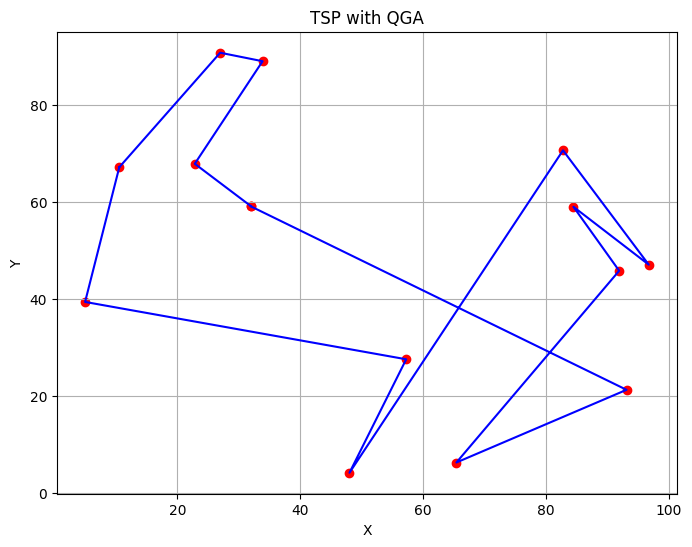

In [ ]:
executeQuantumGA()